In [4]:
# matplotlib for plotting
import matplotlib.pyplot as plt

# numpy to calculate RMS with np.std()
import numpy as np

# pandas used for handling the large amounts of data in dataframes rather than python lists
import pandas as pd

# scipy for curve fitting
from scipy.optimize import curve_fit

# Import datetime to get current date and time to title directory
from datetime import datetime

# Import os to create directories and store plots in them
import os

# Imprt sys to all command arguments to get passed for analysis
import sys

# Create a directory with the name: hit_reconstruction_MM-DD-YYYY_HHMMSS
current_dateTime = datetime.now()
date_string = str('%02d' %current_dateTime.month) + '-' + str('%02d' %current_dateTime.day) + '-' \
    + str('%04d' %current_dateTime.year) + '_' + str('%02d' %current_dateTime.hour) + str('%02d' %current_dateTime.minute) \
    + str('%02d' %current_dateTime.second)

# Name the 'main' directory. This will hold the sub-directories that contain actual plots/data
main_directory = '../Analysis_Results/Analysis_' + date_string 

# Name the subdirectories:
    # reconstruct directory will hold the reconstruction plots
    # plot directory will hold intermediate plots (created from process) and the fit parameters
    # intermidiate directory will store TOA vs RMS plots to help diagnose outliers
reconstruct_directory = main_directory + '/hit_reconstruction'
iterative_directory = main_directory + '/iterative_results'
TOAvRMS_directory = main_directory + '/TOA_v_RMS'

# Create the main_directory and the 3 sub-directories for reconstruction, TOAvRMS, and process
os.mkdir(main_directory)
os.mkdir(iterative_directory)
os.mkdir(reconstruct_directory)
os.mkdir(TOAvRMS_directory)

# Get current directory path. Used for status statements later
path = os.getcwd()

In [2]:
# Function parameters that are repeated throughout this program are given a '_f' as a suffix. This is to avoid incorrectly 
# overwriting variables.

def theoryFunction(t_f):
    '''
    Returns the theoretical RMS for electron cloud drifting in LAr based on given arrival time(s). 

    Parameters
    ----------
        t_f : array of float or float
            Array of Mean_TOA(s) for each pixel.

    Returns
    -------
        array of float or float: 
            Array of expected RMS' corresponding to the TOA in parameter: t.
    '''
    
    D = 682.23 # mm^2/s
    v = 1.648 * 10**6 # mm/s
    RMS = ((2*(t_f)*D/v**2)**(1/2))
    return RMS

def sqrtFunc(x_f, a_f):
    '''
    Returns the value a*sqrt(x) for given x(s). 

    Parameters
    ----------
        x_f : array of float or float
            Array of independent float values.
        a_f : float
            Scaling factor of the sqrt function.

    Returns
    -------
        array of float or float: 
            Value(s) equal to a*sqrt(x) corresponding to the array parameter x.
    '''
    return a_f*(x_f)**(1/2)

def fitLine(function, x_f, y_f):
    '''
    Returns fitting parameters, dependent on type of fitted line, for a given dataset. 

    Parameters
    ----------
        function : Function
            General mathematical function returning the dependent y-value for a given independent x-value.
        x_f : array of float
            Independent variables corresponding to the y-array.
        y_f : array of float
            Dependent variables corresponding to the x-array.

    Returns
    -------
        array of float: 
            Array of fitting parameters for each needed parameter in function.
    '''
    params, _ = curve_fit(function, x_f, y_f)
    return params

def gaussFunc(x_f, A_f, x0_f, sigma_f):
    '''
    Returns the dependent value on a Gaussian curve for given x(s). 

    Parameters
    ----------
        x_f : array of float or float
            Array of independent float values.
        A_f : float
            Amplitude of the Gaussian curve.
        x0_f : float
            Mean value for the Gaussian distribution.
        sigma_f : float
            Standard Deviation for the Gaussian distribution.

    Returns
    -------
        array of float or float: 
            Dependent value on a Gaussian curve corresponding to the array parameter x.
    '''
    return A_f * np.exp(-(x_f - x0_f) ** 2 / (2 * sigma_f ** 2))

def gaussFitHist(data_f, binNum_f):
    '''
    Takes in a histogram and returns the gaussian fitting parameters for the histogram as well as the points used for fitting. 

    Parameters
    ----------
        data_f : array of float
            Array of values used in histogram distribution.
        binNum_f : int
            Number of bins used in histogram plot.

    Returns
    -------
        gauss_params : array of float or float 
            Fitting parameters used to generate a Gaussian curve fitted to histogram bars.
        gaussDataPoints : DataFrame
            DataFrame filled with xvalues and yvalues of the points in the center and on top of each histogram bar.
    '''
    counts, bins = np.histogram(data_f, bins = binNum_f)
    binCenters = []
    
    for i in range(len(bins) - 1):
        binCenters.append((bins[i]+bins[i+1])/2)

    gaussDataPoints = pd.DataFrame(data={'xvalues': binCenters, 'yvalues': counts
                                        })
                                                   
    gauss_params, _ = curve_fit(gaussFunc, gaussDataPoints["xvalues"], gaussDataPoints["yvalues"],
                                p0 = [gaussDataPoints["yvalues"].max(), data_f.mean(), data_f.std()])
    
    return gauss_params, gaussDataPoints

def getBinNum(binNum_f, maxVal0_f, minVal0_f, maxVal_new_f, minVal_new_f):
    '''
    Returns a bin number, proportional to the original bin number, for a subset of data. 

    Parameters
    ----------
        binNum_f : int
            Original number of bins used in histogram plot.
        maxVal0_f : float
            Max value on the histogram when binning using binNum.
        minVal0_f : float
            Min value on the histogram when binning using binNum.
        maxVal_new_f : float
            Max value on the histogram for the subset of data.
        minVal_new_f : float
            Min value on the histogram for the subset of data.

    Returns
    -------
        newBinNum : int
            Bin number used for the subset of data that will maintain the midth of the original bins.
    '''
    newBinNum = abs(int(binNum_f * (maxVal_new_f - minVal_new_f)/(maxVal0_f - minVal0_f)))
    if newBinNum == 0:
        return 1
    else:
        return newBinNum

def getOutliers(dataFrame_f, gaussParams_f, indices_min_stdev_f, numSigma_f):
    '''
    Returns a list of the outliers in a given dataframe based on given gaussian parameters. 

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with one column named 'delta_StDev' for each pixel.
        gaussParams_f: array of float
            Gaussian parameters created from fitting a 1D histogram of the 'delta_StDev' dataFrame column.
        indices_min_stdev_f : array of int
            Array of row indices of the minimum StDev of each event.
        numSigma_f : int
            Number of standard deviations away from mean required to define an outlier.

    Returns
    -------
        outliers : DataFrame
            DataFrame with one column 'Event_Outlier' containing boolean values:
                True: Pixel's delta_StDev is outside numSigma sigma from mean
                False: Pixel's delta_StDev is within numSigma sigma from mean
                NaN: Pixel is not the minimum StDev for the given event, hence it is not considered for outliers.                                                               
    '''
    # Record the outliers from the distribution (pixels where Delta_StDev is outside 3 sigma)
    gaussFit_sigma = gaussParams_f[2]
    gaussFit_mean = gaussParams_f[1]
    max_deltaStDev = gaussFit_mean + numSigma*gaussFit_sigma
    min_deltaStDev = gaussFit_mean - numSigma*gaussFit_sigma

    # Return an 'Event_Outlier' Column, set non min_StDev rows to NaN as they are excluded from outlier arg.
    # True is pixel is an outlier, False else
    df_copy = dataFrame_f.copy().reset_index(drop = True)
    df_copy["Event_Outlier"] = (df_copy.loc[indices_min_stdev_f]["delta_StDev"] > max_deltaStDev) | (df_copy.loc[indices_min_stdev_f]["delta_StDev"] < min_deltaStDev)
    outliers = pd.DataFrame(data = {"Event_Outlier": df_copy["Event_Outlier"]})
    return outliers

def createPlots(dataFrame_f, indices_min_stdev_f, old_lineParams_f, new_lineParams_f, gaussParams_f, binNum_f, iterationNum):
    '''
    Creates two plots, a histogram and scatter plot, for a given iteration of removing outliers. 

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 'RMS', 'delta_StDev', 'Event_Outlier'.
        indices_min_stdev_f : array of int
            Array of row indices of the minimum StDev of each event.
        old_lineParams_f : array of float
            Array of fitting parameters before considering outliers.
        new_lineParams_f : array of float
            Array of fitting parameters after removing outliers.
        gaussParams_f : array of float
            Gaussian parameters created from fitting a 1D histogram used to identify outliers.
        binNum_f : int
            Number of bins used in the histogram plot.
        iterationNum: int
            Counter used to identify which iteration created this plot.

    Returns
    -------
        None.                                                               
    '''
    # Create the 1D Delta StDev Distribution plot
    # Set plot characteristics:
    plt.figure(figsize=(9,7))
    plt.title('1D Delta StDev Distribution', fontsize = 20)
    plt.xlabel('Delta_StDev (sec)', fontsize=16)

    # Get the proper binNumbers for the different distribution plot:
    norm_binNum = getBinNum(binNum_f, dataFrame_f.iloc[indices_min_stdev_f]["delta_StDev"].max(), 
                       dataFrame_f.iloc[indices_min_stdev_f]["delta_StDev"].min(),
                       dataFrame_f[(dataFrame_f["Event_Outlier"] == False)]["delta_StDev"].max(), 
                       dataFrame_f[(dataFrame_f["Event_Outlier"] == False)]["delta_StDev"].min())
    outlier_binNum = getBinNum(binNum_f, dataFrame_f.iloc[indices_min_stdev_f]["delta_StDev"].max(), 
                       dataFrame_f.iloc[indices_min_stdev_f]["delta_StDev"].min(),
                       dataFrame_f[(dataFrame_f["Event_Outlier"] == True)]["delta_StDev"].max(), 
                       dataFrame_f[(dataFrame_f["Event_Outlier"] == True)]["delta_StDev"].min())
    
    # Plot the histogram distribution
    plt.hist(dataFrame_f[(dataFrame_f["Event_Outlier"] == False)]["delta_StDev"], bins = norm_binNum, color = 'darkorange')
    plt.hist(dataFrame_f[(dataFrame_f["Event_Outlier"] == True)]["delta_StDev"], bins = outlier_binNum, color= 'blue',
                label = 'Outliers')

    # Plot the Gaussian Fit
    xmin, xmax = plt.xlim()
    xs_gauss = np.linspace(xmin, xmax, 1000)
    ys_gauss = gaussFunc(xs_gauss, *gaussParams_f)
    plt.plot(xs_gauss, ys_gauss, '--', color = 'crimson', label = 'Gaussian Fit')
    plt.legend()
    plt.savefig(iterative_directory + '/distribution_iteration_%02d.png' %iterationNum)
    plt.close()
    
    #===========================================================================================================================
    # Create the scatter plot fitted with line: 
    # Set plot characteristics:
    plt.figure(figsize=(8,8))
    plt.title('StDev_Min vs Mean_TOA by Event Num \n(Original Data, Removing Outliers)', fontsize = 20)
    plt.xlabel('mean_TOA (sec)', fontsize=16)
    plt.ylabel('StDev_Min (sec)', fontsize=16)

    # Plot the min_StDev Outliers with coor: [mean_TOA, StDev]
    plt.scatter(dataFrame_f[(dataFrame_f["Event_Outlier"] == True)]["mean_TOA"], 
                dataFrame_f[(dataFrame_f["Event_Outlier"] == True)]["RMS"], s = 6, color = 'blue', label = 'Outliers')

    # Plot the min_StDev normal points (non-Outliers) with coor: [mean_TOA, StDev]
    plt.scatter(dataFrame_f[(dataFrame_f["Event_Outlier"] == False)]["mean_TOA"], 
                dataFrame_f[(dataFrame_f["Event_Outlier"] == False)]["RMS"], s = 6, color = 'darkorange', label = 'Non-Outliers')

    # Create x and y values for the two line fits:
    xs_line = np.linspace(0, dataFrame_f.iloc[indices_min_stdev_f]["mean_TOA"].max(), 1000)
    ys_old = sqrtFunc(xs_line, old_lineParams_f[0])
    ys_new = sqrtFunc(xs_line, new_lineParams_f[0])

    # Plot fit curves
    plt.plot(xs_line, ys_old, color = 'gold', label = 'Best Fit with Outliers', linestyle='--');
    plt.plot(xs_line, ys_new, color = 'green', label = 'Best Fit without Outliers', linestyle='--');
    
    # Plot a theory line from what's expected to happen in LAr
    x_low, x_high = plt.xlim()
    xs_theory = np.linspace(0, x_high, 1000)
    ys_theory = theoryFunction(xs_theory)
    plt.plot(xs_theory, ys_theory, color = 'red', label = 'Theory', linestyle='--')
    plt.legend()
    plt.ylim(0, 10**-6)
    plt.savefig(iterative_directory + '/fit_iteration_%02d.png' %iterationNum)
    plt.close()
    
def getBestFitLine(dataFrame_f, indices_min_stdev_f, lineParams_f, gaussParams_f, binNum_f, numSigma_f, cutoff = -1):
    '''
    Iterative scheme to find the best fit for the min_StDev for each event. 

    This function iterates through a process: 
    Fitting a line -> Get delta_StDev -> Get a gaussian fit -> find new outliers
    This process continues until the new outliers are identical to the previous iteration, or until cutoff
    is reached. Once that occurs, the new dataframe and new fitting parameters (for the line and gaussian) are returned.

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 'RMS', 'delta_StDev', 'Event_Outlier'.
        indices_min_stdev_f : array of int
            Array of row indices of the minimum StDev of each event.
        lineParams_f : array of float
            Array of fitting parameters before considering outliers.
        gaussParams_f : array of float
            Gaussian parameters created from fitting a 1D histogram used to identify first set of outliers.
        binNum_f : int
            Number of bins used in the histogram plot.
        numSigma_f : int
            Number of standard deviations away from mean required to defin outlier.
        cutoff: int, default -1
            Limit to stop function if only want <cutoff> number of iterations.

    Returns
    -------
        dataFrame_cp : DataFrame
            Same dataframe as dataFrame, but values for 'delta_StDev' and 'Event_Outlier' will correspond to last iteration.
        minStDev_fit_params_norm : array of float
            Line fitting parameters for last iteration.
        del_StDev_gauss_params : array of float
            Gaussian fitting parameters for last iteration.
    '''
    # Create soft copy of data frame
    dataFrame_cp = dataFrame_f.copy().reset_index(drop = True)
    
    # Record the outliers from the min_StDev based on the original gaussFit 
    old_Outliers = pd.DataFrame(data = {"Event_Outlier": dataFrame_cp["Event_Outlier"]})
    
    iterationNum = 0
    
    while iterationNum != cutoff:
    
        # Fit the data (excluding outliers) with a func: A*sqrt(mean_TOA):
        minStDev_fit_params_norm = fitLine(sqrtFunc, dataFrame_cp[(dataFrame_cp["Event_Outlier"] == False)]["mean_TOA"], 
                                           dataFrame_cp[(dataFrame_cp["Event_Outlier"] == False)]["RMS"])

        # Get new delta_StDev based on new fitting parameters: minStDev_fit_params_norm
        dataFrame_cp["expected_RMS"] = sqrtFunc(dataFrame_cp["mean_TOA"], minStDev_fit_params_norm[0])
        dataFrame_cp["delta_StDev"] = dataFrame_cp["RMS"] - dataFrame_cp["expected_RMS"]
        
        # Get new Gaussian Distribution for new delta_StDev data
        del_StDev_gauss_params_new, hist_data = gaussFitHist(dataFrame_cp.iloc[indices_min_stdev_f]["delta_StDev"], binNum_f)
        
        # Find new outliers based on new Gaussian distribution
        # To use the chi squared method:
        dataFrame_cp["Event_Outlier"] = getOutliersChi(dataFrame_cp, del_StDev_gauss_params_new, indices_min_stdev_f, numSigma_f)
        # To just use a number of sigma:
#         dataFrame_cp["Event_Outlier"] = getOutliers(dataFrame_cp, del_StDev_gauss_params_new, indices_min_stdev_f, numSigma_f)
        
        iterationNum += 1
        
        # Print fit information:
        print('=====================================================================================================================')
        print('Iteration: %d' %iterationNum)
        print('Gaussian Parameters: A: %3.5E, x0: %3.5E, sigma: %3.5E' %(del_StDev_gauss_params_new[0], 
                                                                         del_StDev_gauss_params_new[1], 
                                                                         del_StDev_gauss_params_new[2]))
        print('Functional Form (Excluding Outliers): %E * sqrt(mean_TOA)' %minStDev_fit_params_norm[0])
        print('=====================================================================================================================')
        
        # If the outliers haven't changed, we are finished. Create plots and return the data
        if dataFrame_cp["Event_Outlier"].equals(old_Outliers["Event_Outlier"]):
            createPlots(dataFrame_cp, indices_min_stdev_f, lineParams_f, minStDev_fit_params_norm, del_StDev_gauss_params_new, 
                        binNum_f, iterationNum)
            return dataFrame_cp, minStDev_fit_params_norm, del_StDev_gauss_params_new 
        
        # Otherwise, store the outlier list for comparison and create plots of given iteration
        else:
            createPlots(dataFrame_cp, indices_min_stdev_f, lineParams_f, minStDev_fit_params_norm, del_StDev_gauss_params_new, 
                        binNum_f, iterationNum)
            old_Outliers["Event_Outlier"] = dataFrame_cp["Event_Outlier"].copy().reset_index(drop = True)

    print("Reached maximum iterations: %d" %cutoff)
    return dataFrame_cp, minStDev_fit_params_norm, del_StDev_gauss_params_new 

def getT0_SingleEvent(dataframe_f, event_num_f, fit_param_f):
    '''
    Returns the final time shift for a given event. 

    This function iterates through a process: 
    Find the pixel with the min_delta_StDev for a given event -> Find delta_t to move the pixel's given StDev onto 
    the expected curve -> Store this delta_t -> Shift all mean_TOA by that delta_t -> Find the pixel with the min_delta_StDev 
    for a given event
    This process continues until the delta_t = 0 (the min_delta_StDev = 0) and the previously stored delta_t is returned.

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 'RMS', 'expected_RMS', 'delta_StDev'.
        event_num_f : int
            Event number for the event we are finding t0 for.
        fit_param_f : array of float
            Array of fitting parameters describing the expected_RMS for a given mean_TOA.

    Returns
    -------
        delta_t_return : float
            The last time shift before delta_t = 0. This is the t0 for the given event.
    '''
    # Create a copy of the dataframe containing only points for a given event 
    event_dataframe = dataframe_f[(dataframe_f["event"] == event_num_f)].copy().reset_index(drop = True)
    
    # Establish a very large delta_t. This will get overwritten, if a large t0 is returned, the function didn't work properly.
    delta_t = float('inf')
    
    while True:
        delta_t_return = delta_t
        
        # Find the delta_StDev for each pixel with their new times
        event_dataframe["expected_RMS"] = sqrtFunc(event_dataframe["mean_TOA"], fit_param_f)
        event_dataframe["delta_StDev"] = event_dataframe["RMS"] - event_dataframe["expected_RMS"]

        # Find the min delta_StDev
        smallest_stdev_index = event_dataframe["delta_StDev"].idxmin()
        smallest_stdev = event_dataframe.iloc[[smallest_stdev_index]]["RMS"][smallest_stdev_index]

        # Assume this StDev fits on our functional form. 
        # Find the expected TOA:
        expected_TOA = (smallest_stdev/fit_param_f)**2
        # Find the delta_T to shift the actual_TOA to expected_TOA
        delta_t = expected_TOA - event_dataframe.iloc[[smallest_stdev_index]]["mean_TOA"][smallest_stdev_index]

        # At this point, if we get delta_t = 0, we have finished the TOA shifting
        if delta_t == 0:
            return delta_t_return
        
        # Shift all pixel's TOA by the delta_t
        event_dataframe["mean_TOA"] = event_dataframe["mean_TOA"] + delta_t
        
def getZValues(dataFrame_f):
    '''
    Returns the Z-position for pixels in an event with a calculated t0. 

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with columns (at least): 'mean_TOA', 't0'.

    Returns
    -------
        dataFrame_f["Z_Position"] : array
            Array containing the expected Z-position based on the electron drift velocity and a calculated t0 for the event.
    '''
    v0 = 1.648 * 10**6 # mm/s
    
    dataFrame_f["Z_Position"] = (dataFrame_f["mean_TOA"] - dataFrame_f["t0"])*v0
    return dataFrame_f["Z_Position"]

def getOutliersChi(dataFrame_f, gaussParams_f, indices_min_stdev_f, contribution_lim):
    '''
    Returns a list of the outliers in a given dataframe based on given gaussian parameters. 

    Parameters
    ----------
        dataFrame_f : DataFrame
            DataFrame with (at least) one column named 'delta_StDev' for each pixel.
        gaussParams_f: array of float
            Gaussian parameters created from fitting a 1D histogram of the 'delta_StDev' dataFrame column.
        indices_min_stdev_f : array of int
            Array of row indices of the minimum StDev of each event.
        numSigma_f : int
            Number of standard deviations away from mean required to define an outlier.
        contribution_lim : int
            Limit of number of chi**2 to define outliers by. 

    Returns
    -------
        outliers : DataFrame
            DataFrame with one column 'Event_Outlier' containing boolean values:
                True: Pixel's delta_StDev is outside numSigma sigma from mean
                False: Pixel's delta_StDev is within numSigma sigma from mean
                NaN: Pixel is not the minimum StDev for the given event, hence it is not considered for outliers.                                                               
    '''
    # Get mean and stDev for deltaStDev distribution
    gaussFit_sigma = gaussParams_f[2]
    gaussFit_mean = gaussParams_f[1]

    # Return an 'Event_Outlier' Column, set non min_StDev rows to NaN as they are excluded from outlier arg.
    # True is pixel is an outlier, False else
    df_copy = dataFrame_f.copy().reset_index(drop = True)
    df_copy["Chi2_Value"] =  (gaussFit_mean - df_copy["delta_StDev"])**2 / gaussFit_sigma**2
    df_copy["Event_Outlier"] = df_copy.loc[indices_min_stdev_f]["Chi2_Value"] >= contribution_lim
    outliers = pd.DataFrame(data = {"Event_Outlier": df_copy["Event_Outlier"]})
    return outliers

In [3]:
# Introduce Global Variables for event num and file paths/names

directory_path = sys.argv[1]
resets_file_name = 'resets_output.txt'
g4_file_name = 'g4_output.txt'

# Define the minimum nResets per pixel to be considered
reset_num = int(sys.argv[2])

# Define number of standard deviations and chi squared away from mean to be considered an outlier
numSigma = 5
chiSquared_Lim = int(sys.argv[3])
binNum = 100
total_events = int(sys.argv[4])

IndexError: list index out of range

In [4]:
# Open the resets_output.txt file and read into pandas dataframe
resets_df = pd.read_csv(directory_path + '/' + resets_file_name)

# Setting Up the DataFrame

In [24]:
# Filter out any pixels that have resets < 3 times (less than 3 occurences in the df)

# Define a new dataframe containing event, x_pixel, y_pixel and how many resets occured at each pixel
num_resets_df = resets_df.groupby(["event", "pixel_x", "pixel_y"], as_index=False).size()

# In the line above, we are defining the dataframe reset_num_df by grouping the rows by event, x_pixel, and y_pixel and
# using .size() to give us the size (number of occurences) of those groups stored in a "size" column. 

# Select only the occurences of pixels with the event == EVENT_NUM and num_resets (size) > reset_num
pixels_Resets = num_resets_df[(num_resets_df["size"] >= reset_num)]

# merge pixels_of_interest with the resets_df based on pixels
merged_df = pixels_Resets.merge(resets_df[["event", "pixel_x", "pixel_y", "reset_time"]], how = 'left', 
                                 on = ["event", "pixel_x", "pixel_y"])

In [6]:
# Find the mean TOA (mean reset_time) for each pixel

# This can be done with .groupby().mean() as it will group the rows of the df by ["event", "pixel_x", "pixel_y"]
# and include a 4th column that is the mean of reset_time for each grouping

# .groupby().mean() calculates the mean of the column that wasn't included in the grouping. In our case we didn't include 
# "reset_time" in the groupby statement, so the 4th column will be the mean of each group's reset_time

mean_TOA_df = merged_df[["event", "pixel_x", "pixel_y", "reset_time"]].groupby(["event", "pixel_x", "pixel_y"], 
                                                                               as_index=False).mean()

# Renames the 4th column from reset_time -> mean_TOA. groupby() keeps the original column names
mean_TOA_df = mean_TOA_df.rename(columns = {"reset_time" : "mean_TOA"})

In [7]:
# Similarly to the previous cell, we can find the RMS of each pixel's reset time by using .groupby().std()
RMS_df = merged_df[["event", "pixel_x", "pixel_y", "reset_time"]].groupby(["event", "pixel_x", "pixel_y"], as_index=False).std()

# Renames the 4th column from reset_time -> mean_TOA. groupby() keeps the original column names
RMS_df = RMS_df.rename(columns = {"reset_time" : "RMS"})

In [8]:
# Merge the mean_TOA_df and RMS_df to have completed datafram with event, pixels, TOA, and RMS
pixelTime_df = mean_TOA_df.merge(RMS_df, how = 'left', on = ["event", "pixel_x", "pixel_y"])

# Create copy df of the complete set: pixelTime_df

main_df = pixelTime_df.copy().reset_index(drop = True)

# Finding t0

In [9]:
# Record a list of the indices of the pixels that have min_StDev for each event
min_stdev_indices = []
for event_num in range(total_events):
    min_stdev_indices.append(main_df[(main_df["event"] == event_num)]["RMS"].idxmin())

In [10]:
# Get plots for mean_TOA vs StDev for every event

#Status Statements:
print('\n\nBeginning Analysis')
print('=======================================================================================================================')
print('Now saving mean_TOA vs StDev plots for %d events.' %total_events)
# scatter plot of mean_TOA vs RMS
for n in range(total_events):
    # set plot features
    plt.figure(figsize=(9,9))
    plt.ylabel('Sigma T (s)', fontsize = 16)
    plt.xlabel('mean_TOA (s)', fontsize =16)
    plt.title('Sigma T vs mean_TOA - Event %d\nnResets = %d' %(n, reset_num), fontsize = 20)

    # plot mean_TOA_df's column "mean_TOA" vs RMS_df's column "RMS"
    plt.hist2d(main_df[(main_df["event"] == n)]["mean_TOA"], main_df[(main_df["event"] == n)]["RMS"], bins=(binNum,binNum), 
               cmin = 1)
    plt.colorbar()
    plt.savefig(TOAvRMS_directory + '/TOA_v_RMS_event_%02d.png' %n)
    plt.close()
    
print('Plots for %d events have been successfully saved' %total_events)
print('Save location: ' + os.path.dirname(path) + iterative_directory[2:] + '/TOA_v_RMS')
print('=======================================================================================================================\n\n')

In [11]:
# Fit the pixels that have min_StDev for each event points with a func: A*sqrt(mean_TOA)
minStDev_fit_params_original = fitLine(sqrtFunc, main_df.iloc[min_stdev_indices]["mean_TOA"], 
                                       main_df.iloc[min_stdev_indices]["RMS"])

# Declare binNum to ensure hist plots and fits are using same bins

# Get the expected RMS from the mean_TOA for the main_df based on the Best Fit above.
# Store into main_df in column 'expected_RMS'
main_df["expected_RMS"] = sqrtFunc(main_df["mean_TOA"], minStDev_fit_params_original[0])

# Get the delta_StDev by subtracting the expectedRMS from the actual
# Store into main_df in column 'delta_StDev'
main_df["delta_StDev"] = main_df["RMS"] - main_df["expected_RMS"]

# Fit the a 1D delta_StDev distribution with a Gaussian
del_StDev_gauss_params, hist_data = gaussFitHist(main_df.iloc[min_stdev_indices]["delta_StDev"], binNum)

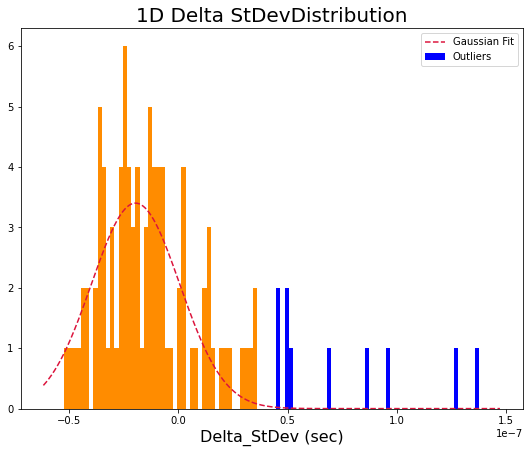

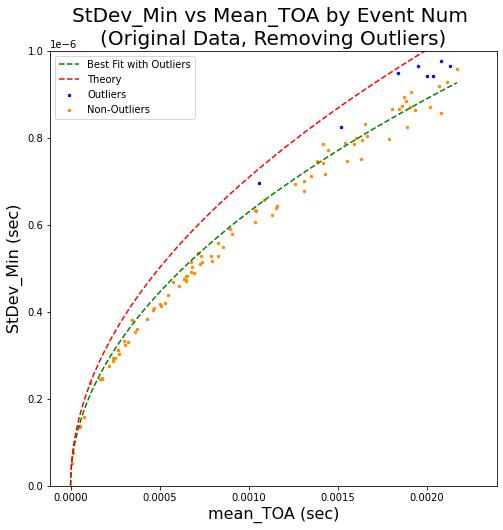

Gaussian Parameters: A: 3.40159E+00, x0: -1.96124E-08, sigma: 2.01870E-08
Functional Form (Including Outliers): 1.989724E-05 * sqrt(mean_TOA)


In [12]:
# Create the plots: 1D delta_StDev Distribution and scatter plot of the pixels that have min_StDev for each event
# with outliers labeled:

# Find outliers:
# Using the Chi squared method:
main_df["Event_Outlier"] = getOutliersChi(main_df,del_StDev_gauss_params, min_stdev_indices, chiSquared_Lim)
# Using number of sigma for outlier definition:
# main_df["Event_Outlier"] = getOutliers(main_df,del_StDev_gauss_params, min_stdev_indices, numSigma)

#===============================================================================================================================

# Create the 1D Delta StDev Distribution plot
# Set plot characteristics:
plt.figure(figsize=(9,7))
plt.title('1D Delta StDevDistribution', fontsize = 20)
plt.xlabel('Delta_StDev (sec)', fontsize=16)

# Get the proper binNumbers for the different distribution plot:
norm_binNum = getBinNum(binNum, main_df.iloc[min_stdev_indices]["delta_StDev"].max(), 
                   main_df.iloc[min_stdev_indices]["delta_StDev"].min(),
                   main_df[(main_df["Event_Outlier"] == False)]["delta_StDev"].max(), 
                   main_df[(main_df["Event_Outlier"] == False)]["delta_StDev"].min())
outlier_binNum = getBinNum(binNum, main_df.iloc[min_stdev_indices]["delta_StDev"].max(), 
                   main_df.iloc[min_stdev_indices]["delta_StDev"].min(),
                   main_df[(main_df["Event_Outlier"] == True)]["delta_StDev"].max(), 
                   main_df[(main_df["Event_Outlier"] == True)]["delta_StDev"].min())

# Plot the histogram distribution
plt.hist(main_df[(main_df["Event_Outlier"] == False)]["delta_StDev"], bins = norm_binNum, color = 'darkorange')
plt.hist(main_df[(main_df["Event_Outlier"] == True)]["delta_StDev"], bins = outlier_binNum, color= 'blue',
            label = 'Outliers')

# Plot the Gaussian Fit
xmin, xmax = plt.xlim()
xs_gauss = np.linspace(xmin, xmax, 1000)
ys_gauss = gaussFunc(xs_gauss, *del_StDev_gauss_params)
plt.plot(xs_gauss, ys_gauss, '--', color = 'crimson', label = 'Gaussian Fit')
plt.legend()
# Save plot in directory
plt.savefig(iterative_directory + '/initial_distribution.png')
plt.close()
    
#===============================================================================================================================
    
# Create the scatter plot fitted with line: 
# Set plot characteristics:
plt.figure(figsize=(8,8))
plt.title('StDev_Min vs Mean_TOA by Event Num \n(Original Data, Removing Outliers)', fontsize = 20)
plt.xlabel('mean_TOA (sec)', fontsize=16)
plt.ylabel('StDev_Min (sec)', fontsize=16)

# Plot the min_StDev Outliers with coor: [mean_TOA, StDev]
plt.scatter(main_df[(main_df["Event_Outlier"] == True)]["mean_TOA"], 
            main_df[(main_df["Event_Outlier"] == True)]["RMS"], s = 6, color = 'blue', label = 'Outliers')

# Plot the min_StDev normal points (non-Outliers) with coor: [mean_TOA, StDev]
plt.scatter(main_df[(main_df["Event_Outlier"] == False)]["mean_TOA"], 
            main_df[(main_df["Event_Outlier"] == False)]["RMS"], s = 6, color = 'darkorange', label = 'Non-Outliers')

# Create x and y values for the two line fits:
xs_line = np.linspace(0, main_df.iloc[min_stdev_indices]["mean_TOA"].max(), 1000)
ys_line = sqrtFunc(xs_line, minStDev_fit_params_original[0])

# Plot fit curves
plt.plot(xs_line, ys_line, color = 'green', label = 'Best Fit with Outliers', linestyle='--')

# Plot a theory line from what's expected to happen in LAr
x_low, x_high = plt.xlim()
xs_theory = np.linspace(0, x_high, 1000)
ys_theory = theoryFunction(xs_theory)
plt.plot(xs_theory, ys_theory, color = 'red', label = 'Theory', linestyle='--');

plt.legend()
plt.ylim(0, 10**-6)
# Save plot in directory
plt.savefig(iterative_directory + '/initial_fit.png')
plt.close()

# Print plot specifics:
print('=======================================================================================================================')
print('Initial fitting parameters:')
print('=======================================================================================================================')
print('Gaussian Parameters: A: %3.5E, x0: %3.5E, sigma: %3.5E' %(del_StDev_gauss_params[0], del_StDev_gauss_params[1], 
                                                             del_StDev_gauss_params[2]))
print('Functional Form (Including Outliers): %E * sqrt(mean_TOA)' %minStDev_fit_params_original[0])
print('Save location: ' + os.path.dirname(path) + iterative_directory[2:] + '/initial_parameters.txt')
print('=======================================================================================================================\n\n')

# Write the plot parameters to text file. Saved in Directory
with open(iterative_directory + '/initial_parameters.txt', 'w') as f:
    f.write('=================================================================\n')
    f.write('nResets = %d \t nSigma = %d \t ChiSquared = %d' %(reset_num, numSigma, chiSquared_Lim))
    f.write('\n')
    f.write('=================================================================\n')
    f.write('Functional form: ' + str(minStDev_fit_params_original[0]) + ' * sqrt(mean_TOA)')
    f.write('\n')
    f.write('=================================================================\n')
    f.write('=================================================================')
    f.write('\n')
    f.write('delta_StDev Gaussian Parameters: \n')
    f.write('mu: ' + str(del_StDev_gauss_params[1]) + '\n')
    f.write('sigma: ' + str(del_StDev_gauss_params[2]))
    f.write('\n')
    f.write('=================================================================\n')

f.close()

Iteration: 1
Gaussian Parameters: A: 3.80477E+00, x0: -1.31587E-08, sigma: 1.74250E-08
Functional Form (Excluding Outliers): 1.951066E-05 * sqrt(mean_TOA)


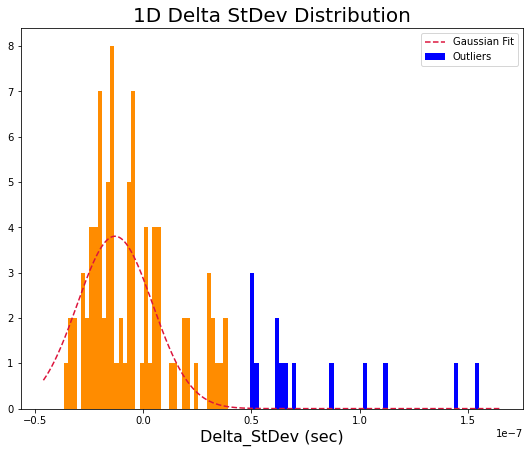

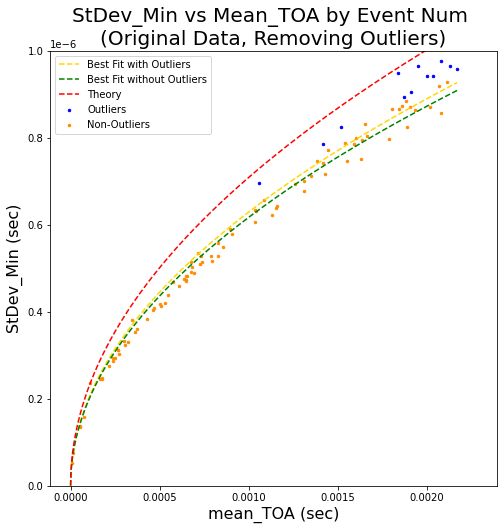

Iteration: 2
Gaussian Parameters: A: 3.72618E+00, x0: -1.20997E-08, sigma: 1.91349E-08
Functional Form (Excluding Outliers): 1.940072E-05 * sqrt(mean_TOA)


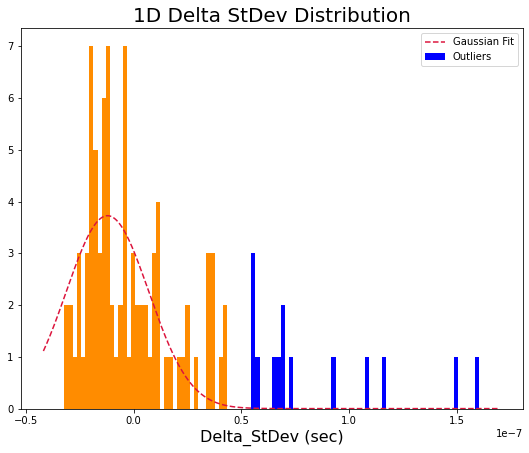

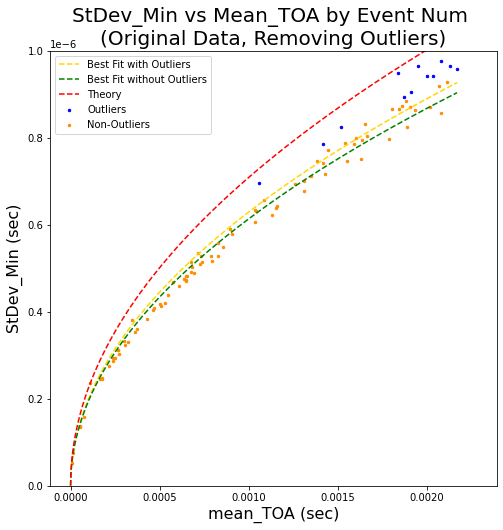

In [13]:
# Get the best fit for the min_StDev dataset by an iterative scheme:
print('=======================================================================================================================')
print('Now removing outliers and refitting: ')
main_df, new_lineParams, new_gauss_Params = getBestFitLine(main_df, min_stdev_indices, minStDev_fit_params_original, 
                                                           del_StDev_gauss_params, binNum, chiSquared_Lim)
print('Refitting process completed.')
print('=======================================================================================================================')

In [14]:
# Create a dataframe t0_df, consisting of the event number and the t0 corresponding to that event
ts = []
events = range(total_events)
for n in events:
    ts.append(getT0_SingleEvent(main_df, n, new_lineParams[0]))
    
t0_df = pd.DataFrame(data ={"event": events, "t0": ts})

Gaussian Parameters: A: 7.24813E+00, x0: -2.27249E-05, sigma: 3.78844E-05


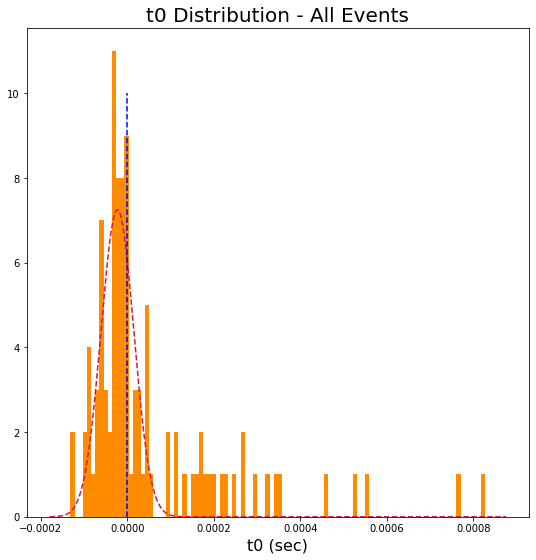

In [15]:
plt.figure(figsize = (9,9))
plt.hist(t0_df["t0"], bins = binNum, color = 'darkorange')

t0_gauss_params, hist_data = gaussFitHist(t0_df["t0"], binNum) 
# Plot the Gaussian Fit
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 1000)
ys = gaussFunc(xs, *t0_gauss_params)
plt.plot(xs, ys, '--', color = 'crimson', label = 'Gaussian Fit')
plt.title('t0 Distribution - All Events', fontsize = 20)
plt.xlabel('t0 (sec)', fontsize = 16)

print('t0 distribution statistics:')
print('Gaussian Parameters: A: %3.5E, x0: %3.5E, sigma: %3.5E' %(t0_gauss_params[0], t0_gauss_params[1], 
                                                                 t0_gauss_params[2]))
# Plot vertical line at t = 0
x = [0]*100
y = np.linspace(0, 10, 100)
plt.plot(x, y, '--', color = 'blue')
# Save plot to directory
plt.savefig(iterative_directory + '/t0_distribution.png')
plt.close()

In [16]:
# Record the functional fit parameter, delta_std gaussian parameters, and t0 distribution parameters in a text file

with open(iterative_directory + '/parameters.txt', 'w') as f:
    f.write('=================================================================\n')
    f.write('nResets = %d \t nSigma = %d \t ChiSquared = %d' %(reset_num, numSigma, chiSquared_Lim))
    f.write('\n')
    f.write('=================================================================\n')
    f.write('Functional form: ' + str(new_lineParams[0]) + ' * sqrt(mean_TOA)')
    f.write('\n')
    f.write('=================================================================\n')
    f.write('=================================================================')
    f.write('\n')
    f.write('delta_StDev Gaussian Parameters: \n')
    f.write('mu: ' + str(new_gauss_Params[1]) + '\n')
    f.write('sigma: ' + str(new_gauss_Params[2]))
    f.write('\n')
    f.write('=================================================================\n')
    f.write('=================================================================')
    f.write('\n')
    f.write('1D t0 Gaussian Parameters: \n')
    f.write('mu: ' + str(t0_gauss_params[1]) + '\n')
    f.write('sigma: ' + str(t0_gauss_params[2]))
    f.write('\n')
    f.write('=================================================================')
    
f.close()

In [17]:
# Record the outliers from the distribution (pixels where Delta_StDev is outside 3 sigma)
t0_sigma = t0_gauss_params[2]
t0_mean = t0_gauss_params[1]
max_t0 = t0_mean + numSigma*t0_sigma
min_t0 = t0_mean - numSigma*t0_sigma


t0_df["t0_Outliers"] = (t0_df["t0"] > max_t0) | (t0_df["t0"] < min_t0)

Gaussian Parameters (Excluding outliers): A: 7.33590E+00, x0: -2.27471E-05, sigma: 3.87269E-05


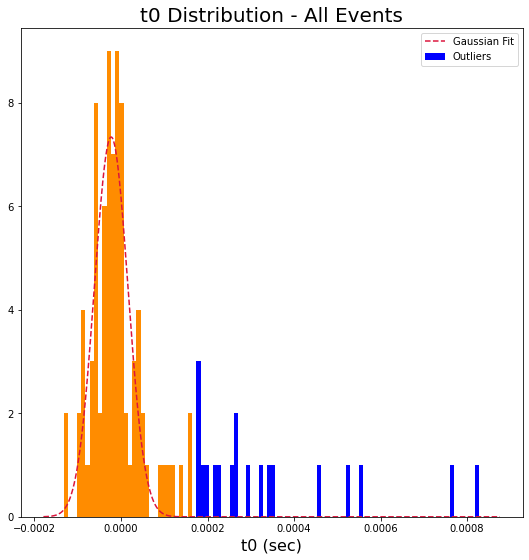

In [18]:
# Recreat the t0 distribution plot but labeling the outliers. Helpful for diagnosing which events have issues.
# There is no data handling or changes happening here, just a visual.

t0_norm_bins = getBinNum(binNum, t0_df["t0"].max(), t0_df["t0"].min(), t0_df[(t0_df["t0_Outliers"] == False)]["t0"].max(), 
                         t0_df[(t0_df["t0_Outliers"] == False)]["t0"].min())
t0_outlier_bins = getBinNum(binNum, t0_df["t0"].max(), t0_df["t0"].min(), t0_df[(t0_df["t0_Outliers"] == True)]["t0"].max(), 
                            t0_df[(t0_df["t0_Outliers"] == True)]["t0"].min())

plt.figure(figsize = (9,9))
plt.hist(t0_df[(t0_df["t0_Outliers"] == False)]["t0"], bins = t0_norm_bins, color = 'darkorange')
plt.hist(t0_df[(t0_df["t0_Outliers"] == True)]["t0"], bins = t0_outlier_bins, color = 'blue', label = 'Outliers')

t0_gauss_params_norm, hist_data = gaussFitHist(t0_df[(t0_df["t0_Outliers"] == False)]["t0"], t0_norm_bins) 
# Plot the Gaussian Fit
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 1000)
ys = gaussFunc(xs, *t0_gauss_params_norm)
plt.plot(xs, ys, '--', color = 'crimson', label = 'Gaussian Fit')
plt.title('t0 Distribution - All Events', fontsize = 20)
plt.xlabel('t0 (sec)', fontsize = 16)
plt.legend()
print('Gaussian Parameters (Excluding outliers): A: %3.5E, x0: %3.5E, sigma: %3.5E' %(t0_gauss_params_norm[0], 
                                                                                      t0_gauss_params_norm[1], 
                                                                                      t0_gauss_params_norm[2]))
print('=======================================================================================================================\n\n')
# Save plot to directory
plt.savefig(iterative_directory + '/t0_distribution_with_outliers.png')
plt.close()

In [ ]:
print('=======================================================================================================================')
print('Final fit parameters, delta_StDev distribution statistics, and t0 distribution statistics have been saved.')
print('Location: ' + os.path.dirname(path) + iterative_directory[2:] + '/parameters.txt')

# Reconstruct and Compare to G4 data

In [19]:
# Open the g4_output.txt file and read into pandas dataframe

g4_df = pd.read_csv(directory_path + '/' + g4_file_name)

In [20]:
# Add the t0 dataframe as a 't0' column to the main_df by aligning the event numbers
reconstruction_df = main_df.copy().reset_index(drop = True)
reconstruction_df = reconstruction_df.merge(t0_df, how = 'left', on = ["event"])

# Convert the pixel numbers to a position in mm
reconstruction_df["X_Position"] = reconstruction_df["pixel_x"] * 4
reconstruction_df["Y_Position"] = reconstruction_df["pixel_y"] * 4
reconstruction_df["Z_Position"] = getZValues(reconstruction_df)

In [21]:
# Record the final dataframe as a csv file stored in iterative_results directory

final_df = reconstruction_df.copy().reset_index(drop = True)
final_df.to_csv(iterative_directory +'/final_dataframe.csv', index=False)
print('\nFinal Dataframe has been saved.\nLocation: ' + os.path.dirname(path)+ iterative_directory[2:] + '/final_dataframe.csv')
print('=======================================================================================================================\n\n')

In [22]:
# Plot the YZ data for event = EVENT_NUM
print('=======================================================================================================================')
print('Creating hit reconstruction plots:')
for n in range(50):
    plt.figure(figsize=(9, 5.4)) # scaled to dimensions of DUNE APA scaled by 1.5

    # Plots lines from (yi, zi) to (yf, zf) for event = EVENT_NUM
    plt.plot([g4_df.yi[(g4_df.event == n)], g4_df.yf[(g4_df.event == n)]],
             [g4_df.zi[(g4_df.event == n)], g4_df.zf[(g4_df.event == n)]])

    # Plot the points from the t0 values
    # Divide by 10 to convert from mm to cm (G4 is in cm)
    plt.scatter(reconstruction_df.Y_Position[(reconstruction_df.event == n)]/10, 
                reconstruction_df.Z_Position[(reconstruction_df.event == n)]/10, s = 2, color = 'red', label = 'Reconstructed Points')


    # labels axes, adds title, and shows the plot.
    plt.xlabel('Y Position (cm)', fontsize=16)
    plt.ylabel('Z Position (cm)', fontsize=16)
    plt.title('G4 Data Plot - YZ - Event %d' %(n), fontsize=20)
    plt.legend()
    plt.savefig(reconstruct_directory + '/event_%02d.png' %n)
    plt.close()
    # For status checking
    if n % 10 == 0:
        print('Finished Event %d of %d total events' %(n, total_events))

Finished Event 0
Finished Event 10
Finished Event 20
Finished Event 30
Finished Event 40


In [23]:
# Plot the YZ data for event = EVENT_NUM
for n in range(50, total_events):
    plt.figure(figsize=(9, 5.4)) # scaled to dimensions of DUNE APA scaled by 1.5

    # Plots lines from (yi, zi) to (yf, zf) for event = EVENT_NUM
    plt.plot([g4_df.yi[(g4_df.event == n)], g4_df.yf[(g4_df.event == n)]],
             [g4_df.zi[(g4_df.event == n)], g4_df.zf[(g4_df.event == n)]])

    # Plot the points from the t0 values
    # Divide by 10 to convert from mm to cm (G4 is in cm)
    plt.scatter(reconstruction_df.Y_Position[(reconstruction_df.event == n)]/10, 
                reconstruction_df.Z_Position[(reconstruction_df.event == n)]/10, s = 2, color = 'red', label = 'Reconstructed Points')


    # labels axes, adds title, and shows the plot.
    plt.xlabel('Y Position (cm)', fontsize=16)
    plt.ylabel('Z Position (cm)', fontsize=16)
    plt.title('G4 Data Plot - YZ - Event %d' %(n), fontsize=20)
    plt.legend()
    plt.savefig(reconstruct_directory + '/event_%02d.png' %n)
    plt.close()
    
    # For status checking
    if n % 10 == 0:
        print('Finished Event %d of %d total events' %(n, total_events))
        
print('Hit reconstruction plots completed.')
print('Plots saved in the directory: ' + os.path.dirname(path) + reconstruct_directory[2:])
print('=======================================================================================================================')

NameError: name 'total_events' is not defined

In [ ]:
# Final print statement for results:

print('\n\nAnalysis successfully run with no errors.')
# Print location of analysis results
print('Results can be found in the directory: ' + os.path.dirname(path) + main_directory [2:])